# Initalization 

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.test.gpu_device_name()

''

In [12]:
import pathlib
data_dir = pathlib.Path(r'\Users\elife\Documents\Jupyter-Notebook\MaskClassification\CMFD-LowetRes') 
count = len(list(data_dir.glob('*/*.jpg')))
print(count)

4655


# Setting up for Training

In [13]:
#Resize image to make better
batch_size = 32
img_height = 128
img_width = 128

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4655 files belonging to 2 classes.
Using 3724 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4655 files belonging to 2 classes.
Using 931 files for validation.


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [18]:
#Last layer can't be relu must be sigmoid
#Sahil added batchnorm after every convulution layer 
#Also changed max to average poolng
#Dont need bias with batch norm
#USe mtcnn for facecam
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3,padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, 3,padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.AveragePooling2D(2,2),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.AveragePooling2D(2,2),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.3), 
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax')
])    

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [19]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)      

In [20]:
# Sahil looks at code one epoch 100 accuracy
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
print(history.history['val_accuracy'][epochs-1])
model.save("128x128")

117/117 [==============================] - 52s 437ms/step - loss: 0.1728 - accuracy: 0.9542 - val_loss: 0.0370 - val_accuracy: 0.9925
0.9924812316894531
INFO:tensorflow:Assets written to: 128x128\assets


In [21]:
model.evaluate(val_ds)


In [29]:
testig = np.asarray(Image.open(r'C:\Users\elife\Documents\Jupyter-Notebook\MaskClassification\VAL\Black.jpg'))
print(model.predict(testig.reshape((1,128,128,3))))
testig = np.asarray(Image.open(r'C:\Users\elife\Documents\Jupyter-Notebook\MaskClassification\CMFD-LowetRes\Wearing-Mask\00001_Mask.jpg'))
print(model.predict(testig.reshape((1,128,128,3))))


[[1.0000000e+00 2.1813575e-11]]
[[2.636604e-08 1.000000e+00]]


In [22]:
np.save('my_history_lowetRes.npy',history.history)

In [ ]:
history=np.load('my_history.npy',allow_pickle='TRUE').ite

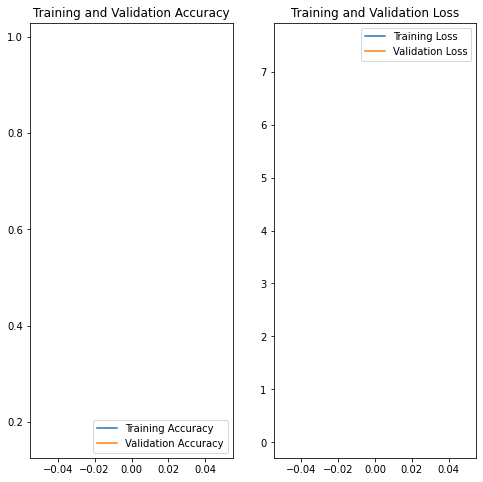

In [96]:

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()